In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import datetime
import missingno as msno


# Libraries for Feature Processing and modelling
from sklearn.preprocessing import StandardScaler, Normalizer,RobustScaler,PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor

# Other utilities
import warnings
warnings.filterwarnings(action='ignore')


#Import the data

In [2]:
train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")

In [3]:
train.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


In [4]:
test.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal


In [5]:
# change the column names to lower case
train.columns=map(str.lower,train.columns)
train.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#Explore the misingness of the values

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             1460 non-null   int64  
 1   mssubclass     1460 non-null   int64  
 2   mszoning       1460 non-null   object 
 3   lotfrontage    1201 non-null   float64
 4   lotarea        1460 non-null   int64  
 5   street         1460 non-null   object 
 6   alley          91 non-null     object 
 7   lotshape       1460 non-null   object 
 8   landcontour    1460 non-null   object 
 9   utilities      1460 non-null   object 
 10  lotconfig      1460 non-null   object 
 11  landslope      1460 non-null   object 
 12  neighborhood   1460 non-null   object 
 13  condition1     1460 non-null   object 
 14  condition2     1460 non-null   object 
 15  bldgtype       1460 non-null   object 
 16  housestyle     1460 non-null   object 
 17  overallqual    1460 non-null   int64  
 18  overallc

In [7]:
total_missing=train.isnull().sum().sort_values(ascending=False)
percent=train.isnull().sum().sort_values(ascending=False)/train.isnull().count().sort_values(ascending=False)
missing_df=pd.concat([total_missing,percent],axis=1,keys=['total_missing','percentage_missing'],sort=False)
missing_df.index.name='variable'# set the index name to variable
missing_df=missing_df[total_missing>0] # only retain those with missing values
missing_df['percentage_missing']=missing_df['percentage_missing'].map(lambda x:x*100) # convert to percentage
missing_df

,total_missing,percentage_missing
variable,,
poolqc,1453,99.520548
miscfeature,1406,96.301370
alley,1369,93.767123
fence,1179,80.753425
masvnrtype,872,59.726027
fireplacequ,690,47.260274
lotfrontage,259,17.739726
garageyrblt,81,5.547945
garagecond,81,5.547945


#Insights
Here we get to see the total number of missing values and their percentages so as to know on what to do with them either do away with them or imput.

#Exploring the categorical values

In [10]:
categorical=train.select_dtypes(include=[object])
categorical.columns


Index(['mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
       'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
       'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
       'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
       'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
       'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
       'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
       'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
       'saletype', 'salecondition'],
      dtype='object')

#Exploring the numerical values

In [9]:
numerical=train.select_dtypes(include=[np.number])
numerical.columns

Index(['id', 'mssubclass', 'lotfrontage', 'lotarea', 'overallqual',
       'overallcond', 'yearbuilt', 'yearremodadd', 'masvnrarea', 'bsmtfinsf1',
       'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', '1stflrsf', '2ndflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'totrmsabvgrd',
       'fireplaces', 'garageyrblt', 'garagecars', 'garagearea', 'wooddecksf',
       'openporchsf', 'enclosedporch', '3ssnporch', 'screenporch', 'poolarea',
       'miscval', 'mosold', 'yrsold', 'saleprice'],
      dtype='object')

#Handling the missingness in the categorical values

Below i try to handle the missingness of the numerical values and the categorical values separately. For the categorical values i used the mode while for the numerical values we use 'mean' for specific columns.

In [11]:
# List of variables for which missing values will be filled with the mode
variables = ['alley', 'miscfeature', 'poolqc', 'fence', 'fireplacequ', 'garagecond',
             'garagequal', 'garagefinish', 'garagetype', 'bsmtfintype2', 'bsmtfintype1',
             'bsmtqual', 'bsmtcond', 'bsmtexposure', 'masvnrtype', 'electrical']

# Fill missing values with the mode
for var in variables:
    if train[var].isnull().any():
        mode_value = train[var].mode()[0]
        train[var].fillna(mode_value, inplace=True)

# Verify that missing values are filled
print(train[variables].isnull().sum())


alley           0
miscfeature     0
poolqc          0
fence           0
fireplacequ     0
garagecond      0
garagequal      0
garagefinish    0
garagetype      0
bsmtfintype2    0
bsmtfintype1    0
bsmtqual        0
bsmtcond        0
bsmtexposure    0
masvnrtype      0
electrical      0
dtype: int64


In [12]:
# List of numerical variables for which missing values will be filled with the mean
variables = ['lotfrontage', 'garageyrblt', 'masvnrarea']

# Fill missing values with the mean
for var in variables:
    if train[var].isnull().any():
        mean_value = train[var].mean()
        train[var].fillna(mean_value, inplace=True)

# Verify that missing values are filled
print(train[variables].isnull().sum())


lotfrontage    0
garageyrblt    0
masvnrarea     0
dtype: int64


In [13]:
train.isnull().sum().sort_values(ascending=False)

id             0
centralair     0
garageyrblt    0
garagetype     0
fireplacequ    0
              ..
masvnrarea     0
masvnrtype     0
exterior2nd    0
exterior1st    0
saleprice      0
Length: 81, dtype: int64

#Explore the distribution of the data

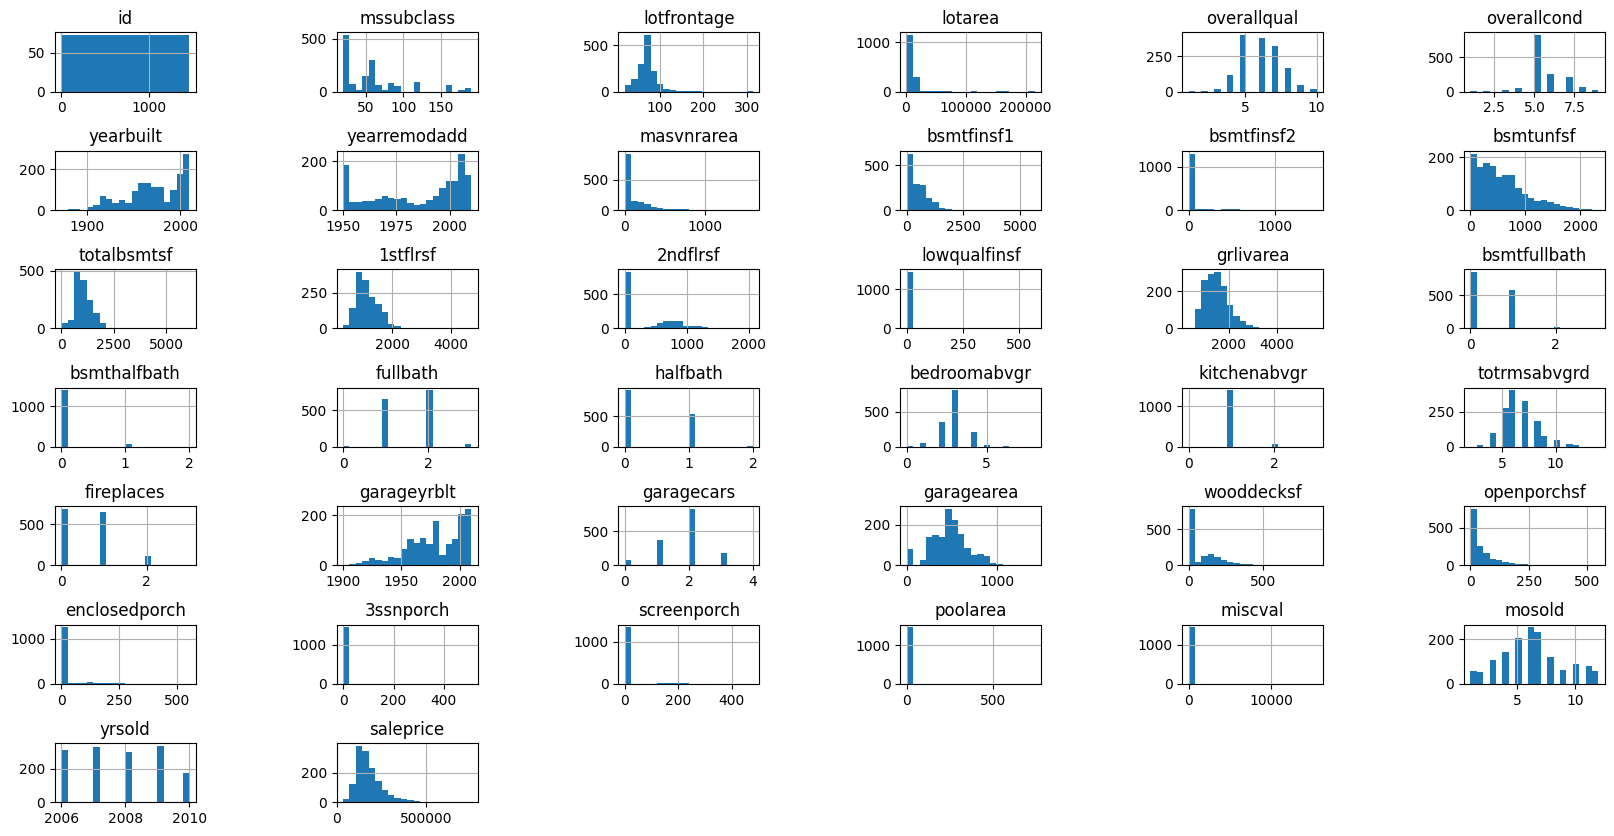

In [16]:
train.hist(figsize=(20,10),bins=20)
plt.subplots_adjust(hspace=1.0,wspace=1.0)

From the above histogram its clear that we have normal, and uniform distribution while others have a big range therefore showing signs of outliers.

#Handling outliers

In [17]:
temporal_vars=[x for x in train.columns if 'yr' in x or  'year' in x]
temporal_vars

['yearbuilt', 'yearremodadd', 'garageyrblt', 'yrsold']

In [18]:
discrete=[x for x in numerical.columns if len(train[x].unique())<25] # get all the discrete variables in the dataset
continous_numerical=[x for x in numerical.columns if x not in temporal_vars+["id"] and x not in discrete]
print("there are {} continous variables in this dataset".format(len(continous_numerical)))

there are 16 continous variables in this dataset


In [19]:
train[continous_numerical].head()

,lotfrontage,lotarea,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,1stflrsf,2ndflrsf,grlivarea,garagearea,wooddecksf,openporchsf,enclosedporch,screenporch,saleprice
0,65.0,8450,196.0,706,0,150,856,856,854,1710,548,0,61,0,0,208500
1,80.0,9600,0.0,978,0,284,1262,1262,0,1262,460,298,0,0,0,181500
2,68.0,11250,162.0,486,0,434,920,920,866,1786,608,0,42,0,0,223500
3,60.0,9550,0.0,216,0,540,756,961,756,1717,642,0,35,272,0,140000
4,84.0,14260,350.0,655,0,490,1145,1145,1053,2198,836,192,84,0,0,250000


I used boxplots for checking the outliers. This is done by checking the percentiles. and comparing them.


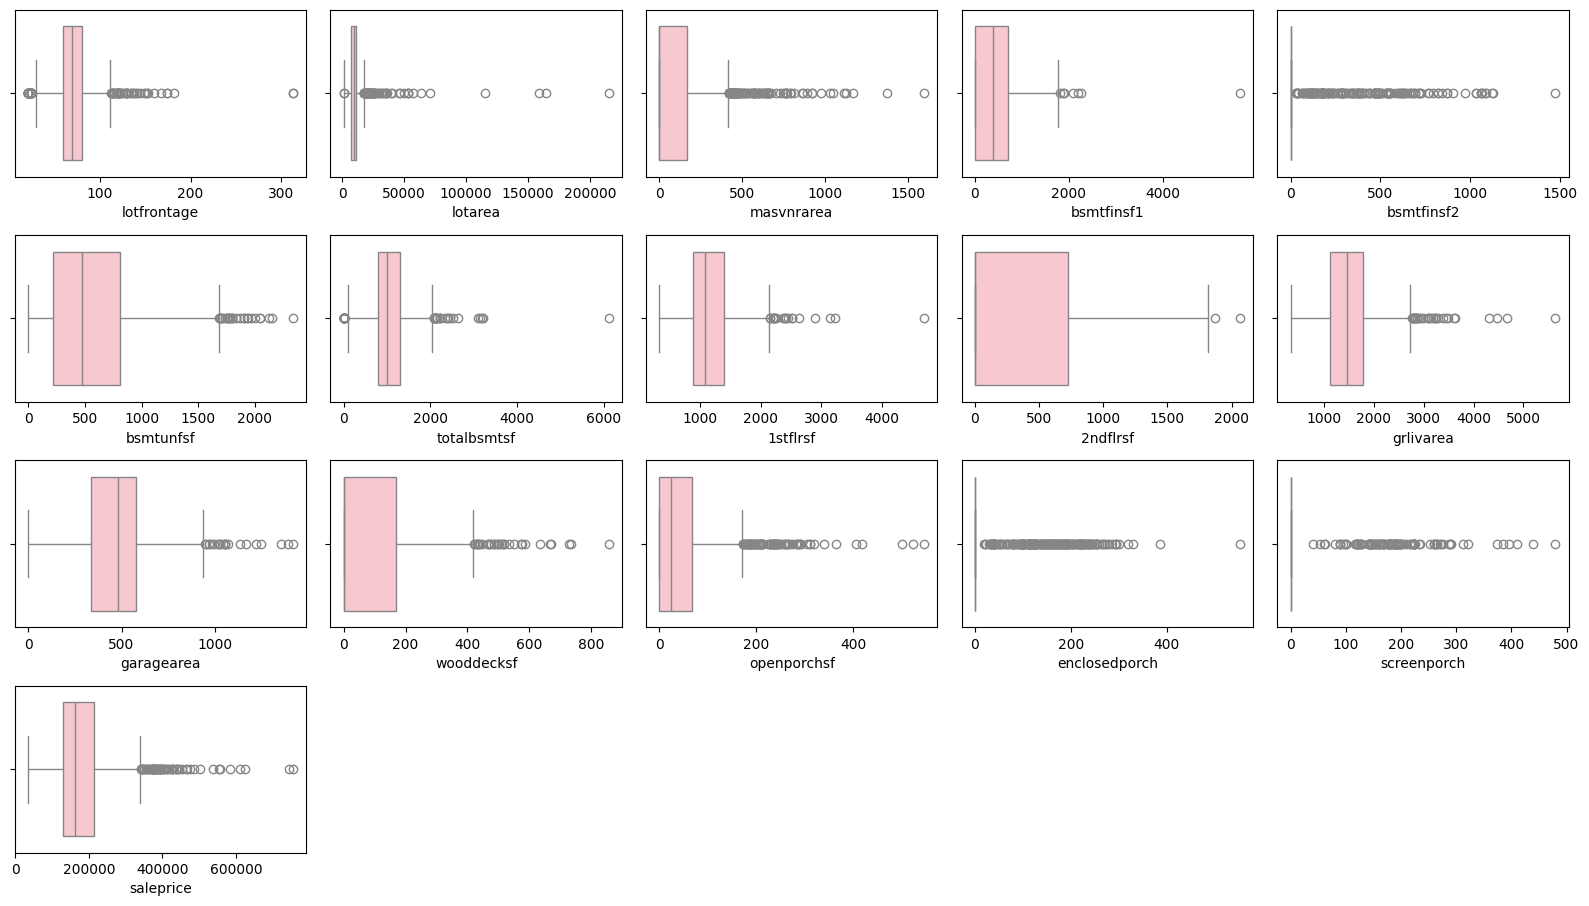

In [21]:

continous_df=numerical[continous_numerical]# get the contious variables data frame

fig=plt.figure(figsize=(16,20))
for var in range(len(continous_df.columns)):
    fig.add_subplot(9,5,var+1)
    sns.boxplot(x=continous_df.iloc[:,var],color="pink")
plt.tight_layout()
plt.show()

I used Label Encoding since its suitable when there is an intrinsic order in the categories which i observed in the categorical variables.

In [31]:


categorical_vars = [
    'mszoning', 'street', 'alley', 'lotshape', 'landcontour', 'utilities',
    'lotconfig', 'landslope', 'neighborhood', 'condition1', 'condition2',
    'bldgtype', 'housestyle', 'roofstyle', 'roofmatl', 'exterior1st',
    'exterior2nd', 'masvnrtype', 'exterqual', 'extercond', 'foundation',
    'bsmtqual', 'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2',
    'heating', 'heatingqc', 'centralair', 'electrical', 'kitchenqual',
    'functional', 'fireplacequ', 'garagetype', 'garagefinish', 'garagequal',
    'garagecond', 'paveddrive', 'poolqc', 'fence', 'miscfeature',
    'saletype', 'salecondition'
]

train_encoded = train.copy()

# Initialize the label encoder.
le = LabelEncoder()

# Apply label encoding to each categorical variable
for var in categorical_vars:
    train_encoded[var] = le.fit_transform(train_encoded[var].astype(str))

train_encoded.head()


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,3,65.0,8450,1,0,3,3,0,...,0,2,2,2,0,2,2008,8,4,208500
1,2,20,3,80.0,9600,1,0,3,3,0,...,0,2,2,2,0,5,2007,8,4,181500
2,3,60,3,68.0,11250,1,0,0,3,0,...,0,2,2,2,0,9,2008,8,4,223500
3,4,70,3,60.0,9550,1,0,0,3,0,...,0,2,2,2,0,2,2006,8,0,140000
4,5,60,3,84.0,14260,1,0,0,3,0,...,0,2,2,2,0,12,2008,8,4,250000


## Opted for robust scaler as it remains resilient against outliers within the data by employing the median and interquartile range for the scaling process.

In [34]:
scaler = RobustScaler()
X = scaler.fit_transform(train_encoded.drop(['saleprice'],axis=1))
X = pd.DataFrame(X,columns=train_encoded.drop(['saleprice'],axis=1).columns)
X.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,screenporch,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition
0,-1.000000,0.2,0.0,-0.265787,-0.254076,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.333333,0.0,0.0,0.0
1,-0.998629,-0.6,0.0,0.523686,0.030015,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.333333,-0.5,0.0,0.0
2,-0.997258,0.2,0.0,-0.107893,0.437624,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0
3,-0.995888,0.4,0.0,-0.528945,0.017663,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.333333,-1.0,0.0,-4.0
4,-0.994517,0.2,0.0,0.734213,1.181201,0.0,0.0,-1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,0.0,0.0,0.0


###Split the data

In [35]:
y =train_encoded.saleprice
x_train,x_test,y_train,y_test = train_test_split(X,y,random_state=48,test_size=.3)
print(x_train.shape,y_train.shape,x_test.shape,y_test.shape)


(1022, 80) (1022,) (438, 80) (438,)


#Linear regression

In [40]:
# Initialize and train the model
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)


# Predict and test the accuracy of the model
y_pred = linear_model.predict(x_test)


rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print('Linear Regression RMSE:', rmse)
print('Linear Regression MAE:', mae)
print('Linear Regression R^2:', r2)

Linear Regression RMSE: 40762.435475832644
Linear Regression MAE: 20317.486102554336
Linear Regression R^2: 0.7022435349500626


##DECISION TREE REGRESSOR MODEL

In [43]:
# Initialize and train the model
tree_model = DecisionTreeRegressor(random_state=42)
tree_model.fit(x_train, y_train)

# Predict and test the accuracy of the model
y_pred = tree_model.predict(x_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print('DecisionTreeRegressor RMSE:', rmse)
print('DecisionTreeRegressor MAE:', mae)
print('DecisionTreeRegressor R^2:', r2)


DecisionTreeRegressor RMSE: 38515.19478597799
DecisionTreeRegressor MAE: 24728.64383561644
DecisionTreeRegressor R^2: 0.734169291744789


###GradientBoostingRegressor Model

In [49]:

# Initialize and train the model
gboost_model = GradientBoostingRegressor(random_state=42)
gboost_model.fit(x_train, y_train)

# Predict and test the accuracy of the model
y_pred = gboost_model.predict(x_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print('GradientBoostingRegressor RMSE:', rmse)
print('GradientBoostingRegressor MAE:', mae)
print('GradientBoostingRegressor R^2:', r2)


GradientBoostingRegressor RMSE: 25564.90086020168
GradientBoostingRegressor MAE: 15790.687758275657
GradientBoostingRegressor R^2: 0.8828805088173737


#Final insights.
I used three models for this project; linear regression, decision tree and the gradientboosting regressor.
All of them performed so well.
The gradiet boosting regressor performed better that all of the them.